In [1]:
# set parameters
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = False

In [2]:
# define functions
def find_nearest_loc(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def defensive_CR(df, HP, AC):
    n = df.shape[0]
    id = find_nearest_loc(df['HP Mean'], HP)
    CR_t = df.index[id]
    AC_t = df['AC'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AC - AC_t)))))
    CR = df.index[id]
    return CR

def offensive_CR(df, DPR, AB):
    n = df.shape[0]
    id = find_nearest_loc(df['DPR Mean'], DPR)
    CR_t = df.index[id]
    AB_t = df['AB'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AB - AB_t)))))
    CR = df.index[id]
    return CR

In [3]:
# import data
dfD = pd.read_csv('dmg-targets-cr-and-xp.csv') # 'CR','PB','XP','AC','HP Mean','AB','DPR Mean'
dfD['eHP Mean']  = dfD['HP Mean' ]*np.power(1.05, dfD['AC'] - 12)
dfD['eDPR Mean'] = dfD['DPR Mean']*np.power(1.05, dfD['AB'] -  2)
dfD['eXP Mean'] = 0.25*dfD['eHP Mean']*dfD['eDPR Mean']
dfD.set_index('CR', inplace=True)


df0 = pd.read_csv('monster-cr-and-xp.csv')  # 'Book','Page','Type','Category','Legendary','CR','PB','XP',
                                            # 'HP','AC','adj HP','adj AC',
                                            # 'AB','adj AB','DPR', 'adj DPR'

df0['D-CR DMG'] = df0.apply(lambda row: defensive_CR(dfD, row['adj HP'], row['adj AC']), axis=1)
df0['O-CR DMG'] = df0.apply(lambda row: offensive_CR(dfD, row['adj DPR'], row['adj AB']), axis=1)
df0['C-CR DMG'] = 0.5*(df0['D-CR DMG'] + df0['O-CR DMG'])

df0['D-CR DMG Delta'] = df0['D-CR DMG'] - df0['CR']
df0['O-CR DMG Delta'] = df0['O-CR DMG'] - df0['CR']
df0['C-CR DMG Delta'] = df0['C-CR DMG'] - df0['CR']

df0['D-CR DMG unadj'] = df0.apply(lambda row: defensive_CR(dfD, row['HP'], row['AC']), axis=1)
df0['O-CR DMG unadj'] = df0.apply(lambda row: offensive_CR(dfD, row['DPR'], row['AB']), axis=1)
df0['C-CR DMG unadj'] = 0.5*(df0['D-CR DMG unadj'] + df0['O-CR DMG unadj'])
print('Includes {} monsters in database'.format(len(df0.index.to_list())))

Includes 1437 monsters in database


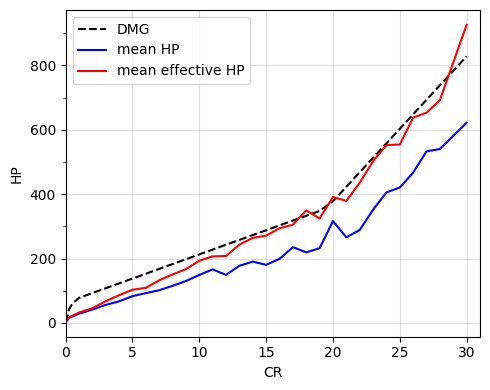

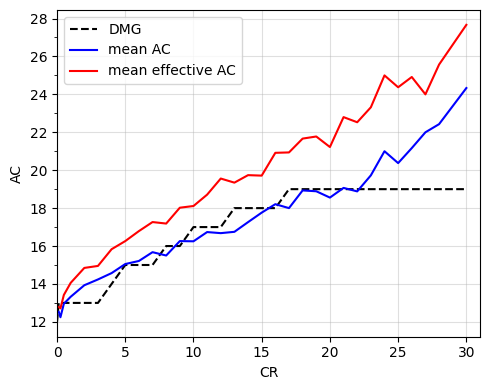

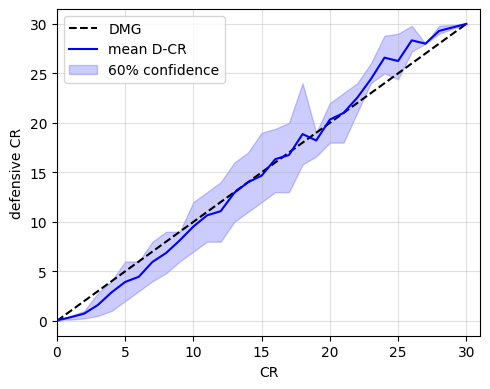

In [4]:
# AC, HP, D-CR
dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# hit points
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='HP')
ax.plot(dfD0.index, dfD0['HP Mean'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['HP'], '-', color='b', label='mean HP')
ax.plot(dfG.index, dfG['adj HP'], '-', color='r', label='mean effective HP')
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('hp-vs-cr.svg', metadata=METADATA)

# armor class
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='AC')
ax.plot(dfD0.index, dfD0['AC'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['AC'], '-', color='b', label='mean AC')
ax.plot(dfG.index, dfG['adj AC'], '-', color='r', label='mean effective AC')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('ac-vs-cr.svg', metadata=METADATA)

# D-CR
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='defensive CR')
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['D-CR DMG'], '-', color='b', label='mean D-CR')
ax.fill_between(dfG.index, dfL['D-CR DMG'], dfU['D-CR DMG'], alpha=0.2, color='b', label='60% confidence')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('d-cr-vs-cr.svg', metadata=METADATA)

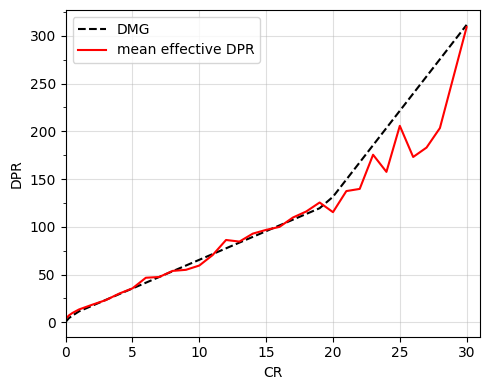

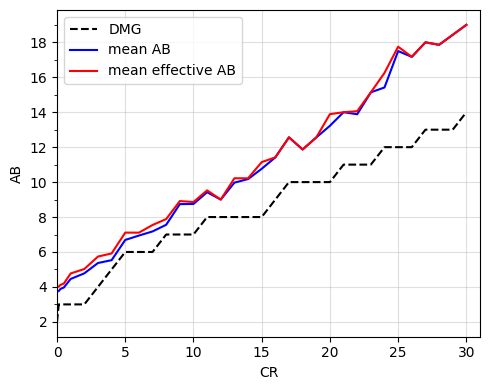

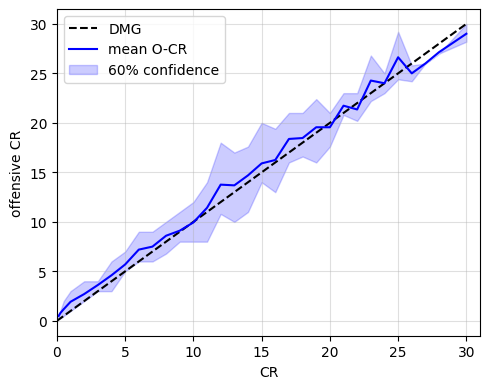

In [5]:
# DPR, AB, O-CR
dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# damage per round
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='DPR')
ax.plot(dfD0.index, dfD0['DPR Mean'], '--', color='k', label='DMG')
#ax.plot(dfG.index, dfG['DPR'], '-', color='b', label='mean DPR')
ax.plot(dfG.index, dfG['DPR'], '-', color='r', label='mean effective DPR')
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('dpr-vs-cr.svg', metadata=METADATA)

# attack bonus
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='AB')
ax.plot(dfD0.index, dfD0['AB'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['AB'], '-', color='b', label='mean AB')
ax.plot(dfG.index, dfG['adj AB'], '-', color='r', label='mean effective AB')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('ab-vs-cr.svg', metadata=METADATA)

# O-CR
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='offensive CR')
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['O-CR DMG'], '-', color='b', label='mean O-CR')
ax.fill_between(dfG.index, dfL['O-CR DMG'], dfU['O-CR DMG'], alpha=0.2, color='b', label='60% confidence')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('o-cr-vs-cr.svg', metadata=METADATA)

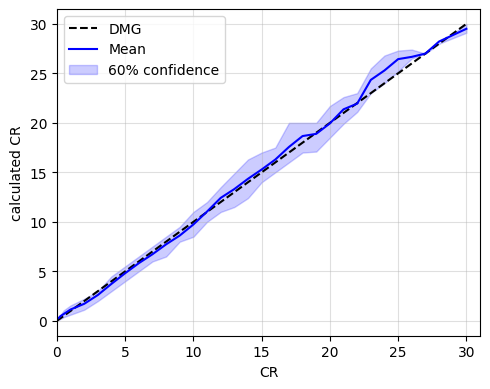

In [6]:
# DMG CR
dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

if SAVEFIGS: plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

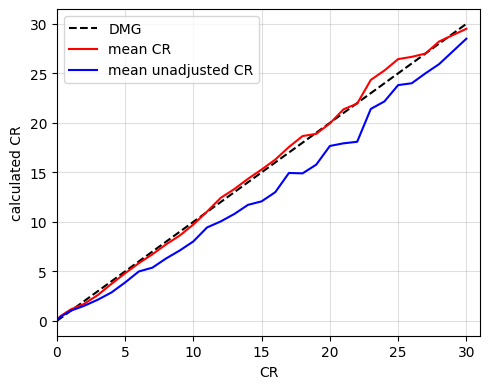

In [7]:
# DMG CR
dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# CR
ylab = 'calculated CR'
fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['C-CR DMG'], '-', color='r', label='mean CR')
ax.plot(dfG.index, dfG['C-CR DMG unadj'], '-', color='b', label='mean unadjusted CR')
#ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#if SAVEFIGS: plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)